In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-08-28_16-24_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

NQ       0.25
YM       0.25
ES       0.25
GC       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    11296.8
GC     5596.0
NQ      154.8
YM     2218.2
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

19265.800000000003

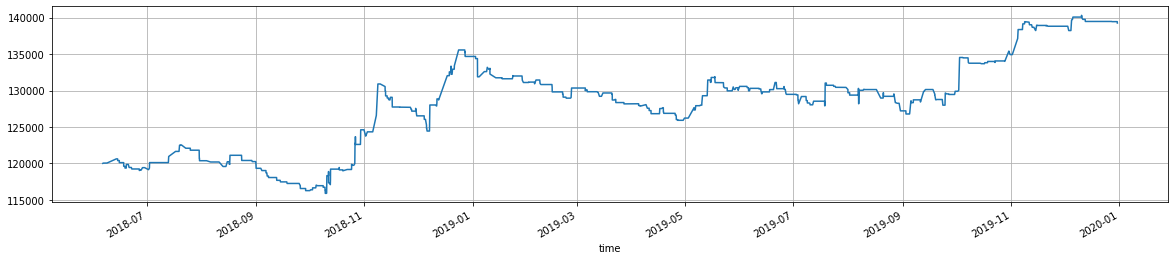

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES    192
 GC    201
 NQ    112
 YM    108
 Name: action, dtype: int64,
 613)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.469438
 GC    0.491443
 NQ    0.273839
 YM    0.264059
 Name: action, dtype: float64,
 1.4987775061124695)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    403.20
GC    486.42
NQ    235.20
YM    226.80
Name: commission, dtype: float64

In [15]:
df.commission.sum()

1351.6200000000001

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.47,55.96,391.76,-241.82,1.62,55.96,100.0
NQ,0.36,2.76,397.30,-216.42,1.84,4.52,56.0
ES,0.39,117.68,1146.48,-527.51,2.17,125.35,96.0
YM,0.33,41.08,869.69,-373.23,2.33,36.93,54.0
total,0.40,62.96,692.07,-354.17,1.95,64.33,306.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.029066,-0.043023,0.234596,0.838664
GC,0.029066,1.000000,0.072003,0.020256,0.373525
NQ,-0.043023,0.072003,1.000000,-0.011060,0.177906
YM,0.234596,0.020256,-0.011060,1.000000,0.562830
total,0.838664,0.373525,0.177906,0.562830,1.000000


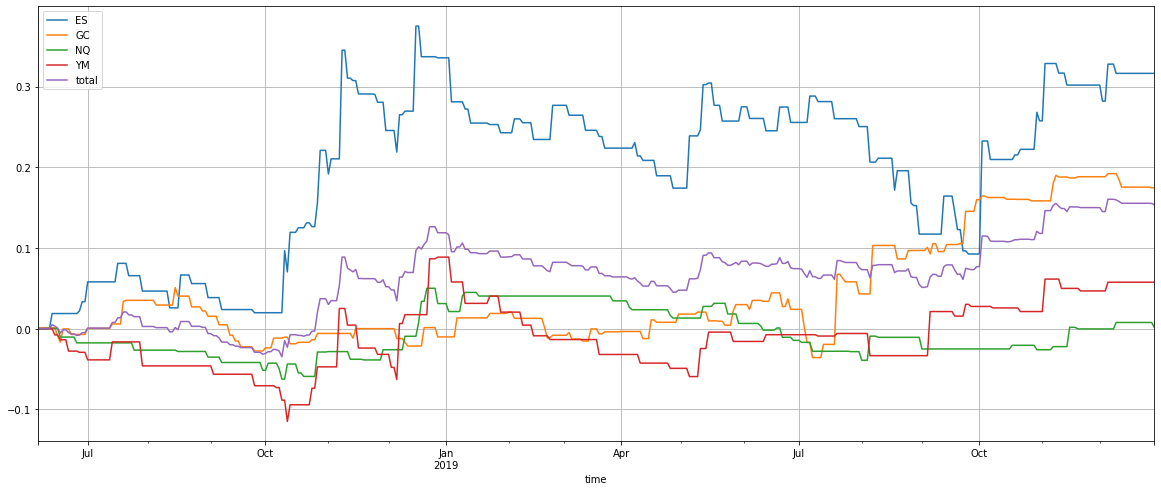

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

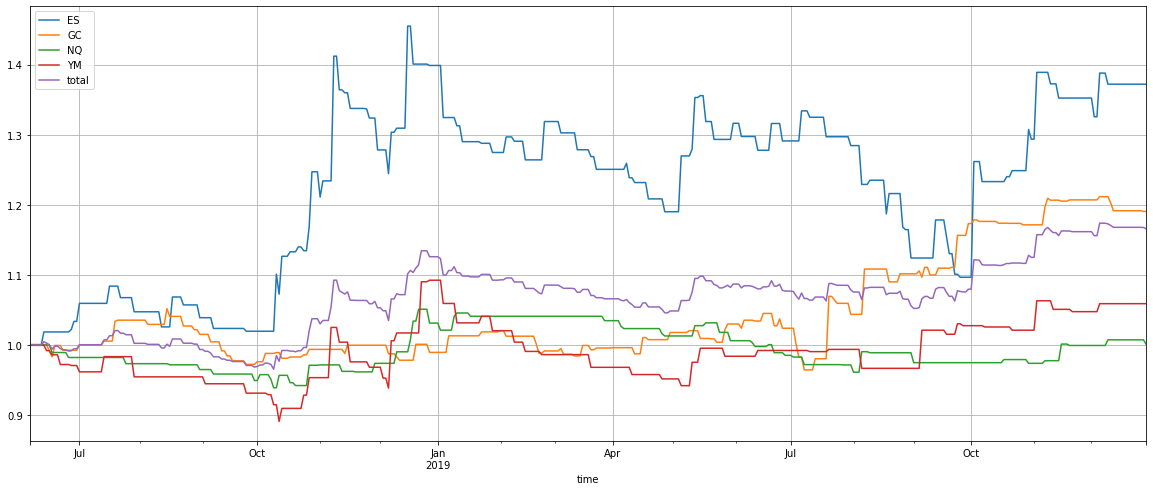

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.215194,0.113565,0.000781,0.036144,0.099250
Cumulative returns,0.372086,0.190749,0.001267,0.059319,0.166005
Annual volatility,0.278848,0.123044,0.069626,0.143743,0.093052
Sharpe ratio,0.832039,0.934059,0.045662,0.316936,1.063054
Calmar ratio,0.874799,1.367569,0.009146,0.262809,1.274227
Stability,0.380367,0.585787,0.021676,0.293416,0.661835
Max drawdown,-0.245993,-0.083042,-0.085359,-0.137528,-0.077890
Omega ratio,1.375857,1.451417,1.019869,1.165091,1.338458
Sortino ratio,1.869448,2.152542,0.080641,0.636779,2.218837
Skew,4.163125,5.653889,2.778190,4.344750,2.634443


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,3.41,-0.70,-1.74,-2.88,-0.49
2018-07-31,1.32,4.32,-0.90,-1.67,0.78
2018-08-31,-0.80,-1.95,-0.86,0.00,-0.88
2018-09-30,-1.86,-4.21,-1.62,-2.43,-2.53
2018-10-31,22.27,2.20,2.29,2.37,7.12
2018-11-30,2.49,0.59,0.28,1.56,1.50
2018-12-31,9.42,-1.02,5.89,12.80,6.91
2019-01-31,-8.86,2.95,0.94,-6.58,-2.97
2019-02-28,3.46,-2.66,0.00,-3.34,-0.64


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES       37.0
GC       19.0
NQ        0.0
YM        6.0
total    17.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:49:00,ES,BUY,2893.50,4508.30
2018-11-08 13:33:30,ES,SELL,2806.50,4320.80
2018-12-17 17:03:00,ES,BUY,2597.00,3333.30
2019-07-19 00:20:00,GC,SELL,1449.50,3025.16
2018-10-10 18:24:00,ES,BUY,2846.00,2395.80
...,...,...,...,...
2018-12-19 20:32:30,ES,BUY,2563.75,-1116.70
2019-08-19 08:28:30,ES,BUY,2912.50,-1166.70
2019-08-27 14:26:00,ES,BUY,2890.50,-1179.20


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-10-02,0.150277,0.004505,0.0,0.000000,0.038696
2018-11-08,0.144027,0.000000,0.0,0.000000,0.036007
2018-12-07,0.047360,0.000000,0.0,0.071860,0.029805
2019-11-04,0.073610,0.000000,0.0,0.041027,0.028659
2018-12-17,0.111110,0.000000,0.0,0.000000,0.027778
...,...,...,...,...,...
2018-11-16,-0.016390,0.000000,0.0,-0.027973,-0.011091
2018-07-30,-0.018890,0.000000,0.0,-0.029280,-0.012043
2018-12-06,-0.026390,-0.012161,0.0,-0.014973,-0.013381
